# Introduction

This notebook is based on roger_exploration_early_stopping.ipynb, which achieved 0.687 AUC on the **validation** set.

## SMOTE
The purpose of this notebook is to investigate the improvement in the model when the model is trained on data that has been augmented by [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/), which is a technique to handle imbalanced data sets.

## Summary
SMOTE doesn't improve the AUC on the validation set
* [Baseline AUC](#Baseline-AUC): 0.687
* [SMOTE AUC](#SMOTE-AUC): 0.682
* [SMOTE and undersampling UAC](#SMOTE-and-undersampling-UAC): 0.633

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from scipy import stats
from joblib import dump
from joblib import load
import xgboost as xgb
import matplotlib.pyplot as plt
from typing import Dict
from kaggle.api.kaggle_api_extended import KaggleApi
from dotenv import find_dotenv, load_dotenv
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from src.data import make_dataset
from src.models.null import NullModel
from src.visualization.visualize import classification_reports, classification_reports_2
from src.visualization.visualize import plot_pie

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
load_dotenv(find_dotenv())
api = KaggleApi()
api.authenticate()

In [4]:
competition = os.environ['COMPETITION']

# Set up directories

In [5]:
project_dir = Path.cwd().parent.parent
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'

# Load data

In [16]:
X_train, X_val, y_train, y_val, X_test = make_dataset.load_sets(interim_data_dir)
test_id = pd.read_csv(interim_data_dir / 'test_id.csv')

# Baseline

The base line prediction is simply to make them all negative.

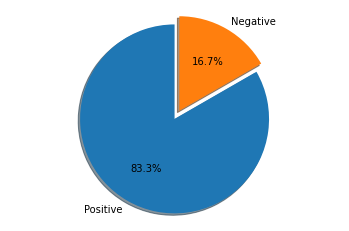

In [17]:
labels = 'Positive', 'Negative'
pos_count = (y_train == 1).sum()
neg_count = (y_train == 0).sum()
sizes = [pos_count, neg_count]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [18]:
pd.Series(y_train).value_counts(normalize=True)

1    0.833125
0    0.166875
Name: TARGET_5Yrs, dtype: float64

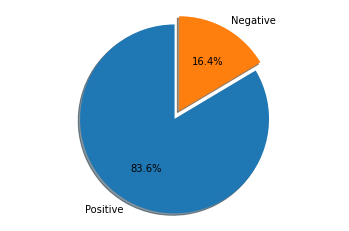

In [19]:
labels = 'Positive', 'Negative'
pos_count = (y_val == 1).sum()
neg_count = (y_val == 0).sum()
sizes = [pos_count, neg_count]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Baseline Score

The baseline score from the previous exploration iteration.

In [20]:
clf_smote = load(models_dir / 'exploratory_xgb.joblib')

In [21]:
best_ntree_limit = clf_smote.get_booster().best_ntree_limit
best_ntree_limit

12

In [23]:
preds_train = clf_smote.predict(X_train, ntree_limit=best_ntree_limit)
probs_train = clf_smote.predict_proba(X_train, ntree_limit=best_ntree_limit)[:, 1]
preds_val = clf_smote.predict(X_val, ntree_limit=best_ntree_limit)
probs_val = clf_smote.predict_proba(X_val, ntree_limit=best_ntree_limit)[:, 1]

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[  13  250]
 [  19 1318]]
Accuracy:  0.831875
AUC:  0.6868379067829629
              precision    recall  f1-score   support

           0       0.41      0.05      0.09       263
           1       0.84      0.99      0.91      1337

    accuracy                           0.83      1600
   macro avg       0.62      0.52      0.50      1600
weighted avg       0.77      0.83      0.77      1600



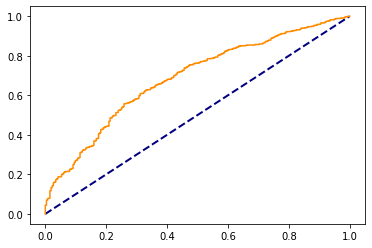

In [24]:
classification_reports_2(y_val, preds_val, probs_val)

### Baseline AUC

The AUC of the validation set is 0.687.

# SMOTE

In [25]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

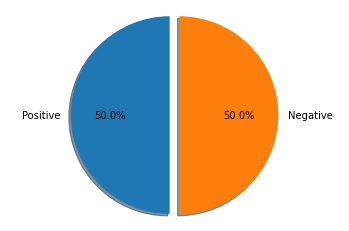

In [26]:
plot_pie(y_train_smote)

In [27]:
pd.Series(y_train).value_counts()

1    5332
0    1068
Name: TARGET_5Yrs, dtype: int64

In [28]:
pd.Series(y_train_smote).value_counts()

0    5332
1    5332
Name: TARGET_5Yrs, dtype: int64

[0]	validation_0-auc:0.66015
[1]	validation_0-auc:0.65881
[2]	validation_0-auc:0.67220
[3]	validation_0-auc:0.67619
[4]	validation_0-auc:0.68163
[5]	validation_0-auc:0.67658
[6]	validation_0-auc:0.68618
[7]	validation_0-auc:0.68246
[8]	validation_0-auc:0.67712
[9]	validation_0-auc:0.67538


c:\users\mactuary\.virtualenvs\assignment_1-rwa_wvyq\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-auc:0.67707
[11]	validation_0-auc:0.67594
[12]	validation_0-auc:0.67515
[13]	validation_0-auc:0.67256
[14]	validation_0-auc:0.67462
[15]	validation_0-auc:0.67064
[16]	validation_0-auc:0.67414
best_ntree_limit: 7
 class 1 :  5332
 class 0 :  5332
Confusion Matrix: 
 [[4305 1027]
 [ 640 4692]]
Accuracy:  0.8436796699174793
AUC:  0.9265794036656201
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      5332
           1       0.82      0.88      0.85      5332

    accuracy                           0.84     10664
   macro avg       0.85      0.84      0.84     10664
weighted avg       0.85      0.84      0.84     10664



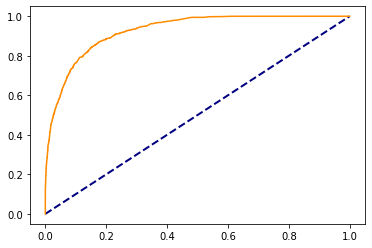

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[  83  180]
 [ 196 1141]]
Accuracy:  0.765
AUC:  0.6861795461719815
              precision    recall  f1-score   support

           0       0.30      0.32      0.31       263
           1       0.86      0.85      0.86      1337

    accuracy                           0.77      1600
   macro avg       0.58      0.58      0.58      1600
weighted avg       0.77      0.77      0.77      1600



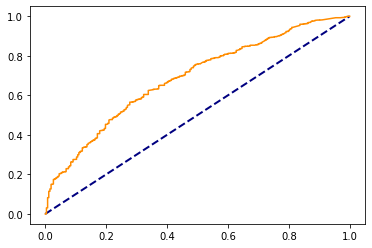

In [29]:
clf_smote = xgb.XGBClassifier(
    eval_metric='logloss')
clf_smote.fit(X_train_smote, 
              y_train_smote,
              eval_metric='auc',
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=10,
              verbose=True)

best_ntree_limit = clf_smote.get_booster().best_ntree_limit
print(f'best_ntree_limit: {best_ntree_limit}')

preds_train = clf_smote.predict(X_train_smote, ntree_limit=best_ntree_limit)
probs_train = clf_smote.predict_proba(X_train_smote, ntree_limit=best_ntree_limit)[:, 1]
preds_val = clf_smote.predict(X_val, ntree_limit=best_ntree_limit)
probs_val = clf_smote.predict_proba(X_val, ntree_limit=best_ntree_limit)[:, 1]


classification_reports(clf_smote, X_train_smote, y_train_smote)
classification_reports(clf_smote, X_val, y_val)

### SMOTE AUC

The SMOTE AUC is 0.682.

## Conclusion

The validation AUC score did not improve; from 0.687 to 0.682.

# SMOTE with undersampling

In [30]:
pd.Series(y_train).value_counts()

1    5332
0    1068
Name: TARGET_5Yrs, dtype: int64

In [31]:
pd.Series(y_train).value_counts(normalize=True)

1    0.833125
0    0.166875
Name: TARGET_5Yrs, dtype: float64

In [32]:
(pd.Series(y_train) == 0).sum() / (pd.Series(y_train) == 1).sum()

0.2003000750187547

In [33]:
for over_perc in np.linspace(0.4, 1, 11):
    print(over_perc)

0.4
0.46
0.52
0.5800000000000001
0.64
0.7
0.76
0.8200000000000001
0.88
0.9400000000000001
1.0


In [34]:
X_smote, y_smote = SMOTE(sampling_strategy=1).fit_resample(X_train, y_train)
pd.Series(y_smote).value_counts()

0    5332
1    5332
Name: TARGET_5Yrs, dtype: int64

In [35]:
np.arange(0.5, 1.05, 0.05)

array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [36]:
X_train_under, y_train_under = RandomUnderSampler(sampling_strategy=0.201).fit_resample(X_train, y_train)
print(pd.Series(y_train_under).value_counts(normalize=True))

1    0.832628
0    0.167372
Name: TARGET_5Yrs, dtype: float64


In [37]:
(pd.Series(y_train_under) == 0).sum() / (pd.Series(y_train_under) == 1).sum()

0.2010163749294184

In [38]:
over_perc

1.0

In [39]:
len(np.arange(0.203, 0.45, 0.05))

5

In [40]:
train_auc_list = []
val_auc_list = []
best_ntree_list = []
n_positive_list = []
n_negative_list = []

for under_perc in np.arange(0.203, 0.45, 0.05):
    print(f'under_perc: {under_perc}')
    X_train_under, y_train_under = RandomUnderSampler(sampling_strategy=under_perc).fit_resample(X_train, y_train)
    for over_perc in np.arange(under_perc + 0.05, 1, 0.05):
        print(f'over_perc: {over_perc}')
        X_train_smote, y_train_smote = SMOTE(sampling_strategy=over_perc).fit_resample(X_train_under, y_train_under)
        
        clf_smote = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        clf_smote.fit(X_train_smote, 
                      y_train_smote,
                      eval_metric='auc',
                      eval_set=[(X_val, y_val)],
                      early_stopping_rounds=10,
                      verbose=False)

        best_ntree_limit = clf_smote.get_booster().best_ntree_limit
        print(f'best_ntree_limit: {best_ntree_limit}')

        preds_train = clf_smote.predict(X_train_smote, ntree_limit=best_ntree_limit)
        probs_train = clf_smote.predict_proba(X_train_smote, ntree_limit=best_ntree_limit)[:, 1]
        preds_val = clf_smote.predict(X_val, ntree_limit=best_ntree_limit)
        probs_val = clf_smote.predict_proba(X_val, ntree_limit=best_ntree_limit)[:, 1]
        
        n_positive_list.append((y_train_smote == 1).sum())
        n_negative_list.append((y_train_smote == 0).sum())
        best_ntree_list.append(best_ntree_limit)
        train_auc_list.append(roc_auc_score(y_train_smote, preds_train))
        val_auc_list.append(roc_auc_score(y_val, preds_val))

result_df = pd.DataFrame({'n_positive': n_positive_list,
                          'n_negative': n_negative_list,
                          'best_ntree': best_ntree_list,
                          'train_auc': train_auc_list,
                          'val_auc': val_auc_list})
# smote = SMOTE(sampling_strategy=0.3)
# under = RandomUnderSampler(sampling_strategy=0.5)

# X_train_smote, y_train_smote = under.fit_resample(X_train, y_train)
# X_train_under, y_train_under = under.fit_resample(X_train_smote, y_train_smote)

under_perc: 0.203
over_perc: 0.253
best_ntree_limit: 21
over_perc: 0.303
best_ntree_limit: 7
over_perc: 0.353
best_ntree_limit: 6
over_perc: 0.40299999999999997
best_ntree_limit: 9
over_perc: 0.45299999999999996
best_ntree_limit: 6
over_perc: 0.5029999999999999
best_ntree_limit: 16
over_perc: 0.5529999999999999
best_ntree_limit: 20
over_perc: 0.603
best_ntree_limit: 11
over_perc: 0.6529999999999999
best_ntree_limit: 3
over_perc: 0.7029999999999998
best_ntree_limit: 8
over_perc: 0.7529999999999999
best_ntree_limit: 2
over_perc: 0.8029999999999998
best_ntree_limit: 9
over_perc: 0.8529999999999999
best_ntree_limit: 7
over_perc: 0.9029999999999999
best_ntree_limit: 13
over_perc: 0.9529999999999998
best_ntree_limit: 6
under_perc: 0.253
over_perc: 0.303
best_ntree_limit: 6
over_perc: 0.353
best_ntree_limit: 20
over_perc: 0.40299999999999997
best_ntree_limit: 17
over_perc: 0.45299999999999996
best_ntree_limit: 9
over_perc: 0.5029999999999999
best_ntree_limit: 11
over_perc: 0.5529999999999999


In [41]:
result_df.sort_values(by=['val_auc'], ascending=False)

,n_positive,n_negative,best_ntree,train_auc,val_auc
60,2650,1995,9,0.797647,0.630779
64,2650,2525,7,0.801125,0.623395
61,2650,2127,3,0.760877,0.621992
57,2650,1597,6,0.738511,0.619839
10,5261,3961,2,0.781783,0.619496
...,...,...,...,...,...
15,4221,1278,6,0.629208,0.531978
2,5261,1857,6,0.678085,0.531448
3,5261,2120,9,0.731872,0.530669
1,5261,1594,7,0.630566,0.527552


## SMOTE and undersampling UAC

Even with different combinations of oversampling and undersampling, the highest validation AUC is 0.633, which is not an improvement.

In [42]:
#
y_train.value_counts()

1    5332
0    1068
Name: TARGET_5Yrs, dtype: int64